In [37]:
import os
from shutil import copyfile
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from PIL import Image

In [2]:
tumor = ['yes', 'no']

In [3]:
os.mkdir(r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\training')
os.mkdir(r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\testing')

In [4]:
for t in tumor:
    os.mkdir(os.path.join(r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\training', t))

In [5]:
os.mkdir(os.path.join(r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\testing', 'test'))

In [6]:
base_path = r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\brain_tumor_dataset'
training_path = r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\training'
testing_path = r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\testing'
test_path = r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\testing\test'

In [7]:
for t in tumor:
    print(t, 'Length:', len(os.listdir(os.path.join(base_path, t))))

yes Length: 155
no Length: 98


In [18]:
for t in os.listdir(base_path):
    img_path = os.path.join(base_path, t)
    count = 0
    threshold = int(0.8*len(os.listdir(img_path)))       #80% images in training path
    
    for image in os.listdir(img_path):
        if count == threshold:
            break
        source = os.path.join(img_path, image)
        dest = os.path.join(training_path, t, image)
        
        img_array = mpimg.imread(os.path.join(img_path, image))
        if len(img_array.shape) == 3:                          #image depth should be 3, ignore 2 depth images
            copyfile(source, dest)
        count += 1
    
    

In [20]:
for t in os.listdir(base_path):
    img_path = os.path.join(base_path, t)
    count = 0
    threshold = int(0.2*len(os.listdir(img_path)))           #20% images in testing path
    
    for image in os.listdir(img_path)[-threshold:]:
        if count == threshold:
            break
        source = os.path.join(img_path, image)
        dest = os.path.join(test_path, image)
        
        img_array = mpimg.imread(os.path.join(img_path, image))
        if len(img_array.shape) == 3:                                   #image depth should be 3, ignore 2 depth images
            copyfile(source, dest)
        count += 1
    

no
Shape: (201, 173, 3) 3


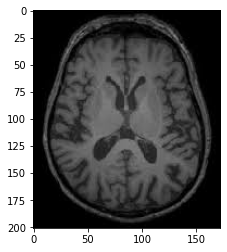

Shape: (168, 300, 3) 3


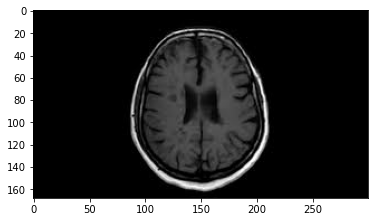

Shape: (183, 275, 3) 3


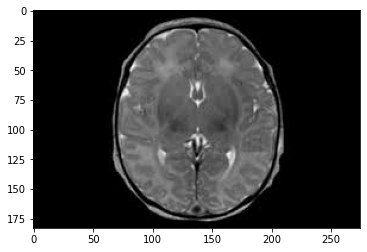

yes
Shape: (218, 180, 3) 3


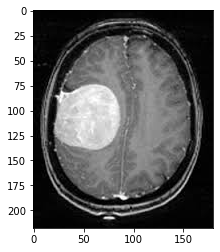

Shape: (348, 287, 3) 3


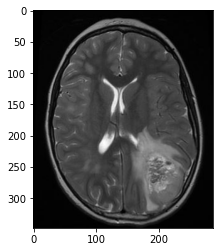

Shape: (630, 587, 3) 3


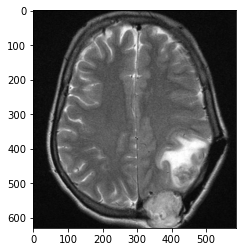

In [19]:
for t in os.listdir(training_path):
    img_path = os.path.join(training_path, t)
    print(t)
    c = 0
    for image in os.listdir(img_path):
        if c == 3:
            break
        img_array = mpimg.imread(os.path.join(img_path, image))
        plt.imshow(img_array)
        print('Shape:', img_array.shape, len(img_array.shape))
        plt.show()
        c += 1
       
        

In [16]:
#defining target image size and batch size
image_size = (240, 240)
batch_size = 16
val_size = 0.2

In [27]:
train_datagen  = ImageDataGenerator(rescale = 1.0/255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.2,
                                    shear_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split = val_size
                                   )

train_generator = train_datagen.flow_from_directory(training_path,
                                                   target_size = image_size,
                                                   batch_size = batch_size,
                                                   class_mode = 'binary',            #only 2 classes so binary will be used
                                                   shuffle = True,
                                                   seed = 10,
                                                   subset = 'training')

val_generator = train_datagen.flow_from_directory(training_path,
                                                target_size = image_size,
                                                class_mode = 'binary',
                                                batch_size = batch_size,
                                                shuffle = True,
                                                seed = 10,
                                                subset = 'validation')

Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [28]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                                                    testing_path,
                                                    target_size = image_size,
                                                    classes = ['test'],
                                                    batch_size = batch_size
                                                  )

Found 42 images belonging to 1 classes.


In [29]:
labels = train_generator.class_indices
labels = dict((v, k) for k,v in labels.items())
labels

{0: 'no', 1: 'yes'}

In [30]:
model = keras.Sequential([
    
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (image_size[0], image_size[1], 3)),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.2),
    
     #CNN2
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.3),
    
    #CNN3
    layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.4),
    
     #Hidden Layers 
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dropout(0.3),
    
    layers.Dense(units = 1, activation = 'sigmoid')              #only 2 classes so sigmoid function
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 119, 119, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 59, 59, 64)       

In [31]:
#compiling the model
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
hist = model.fit(train_generator, epochs = 50, validation_data = val_generator)

Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 1.2772 - accuracy: 0.5972 - val_loss: 0.6888 - val_accuracy: 0.6111
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.6736 - accuracy: 0.5694 - val_loss: 0.6696 - val_accuracy: 0.6111
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.6758 - accuracy: 0.6111 - val_loss: 0.6372 - val_accuracy: 0.6111
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.6491 - accuracy: 0.6042 - val_loss: 0.6536 - val_accuracy: 0.6111
Epoch 5/50
9/9 [==============================] - 17s 2s/step - loss: 0.6676 - accuracy: 0.6319 - val_loss: 0.6517 - val_accuracy: 0.6111
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.6554 - accuracy: 0.6042 - val_loss: 0.6451 - val_accuracy: 0.6111
Epoch 7/50
9/9 [==============================] - 15s 2s/step - loss: 0.6561 - accuracy: 0.6111 - val_loss: 0.6423 - val_accuracy: 0.6111
Epoch 8/50
9/9 [==================

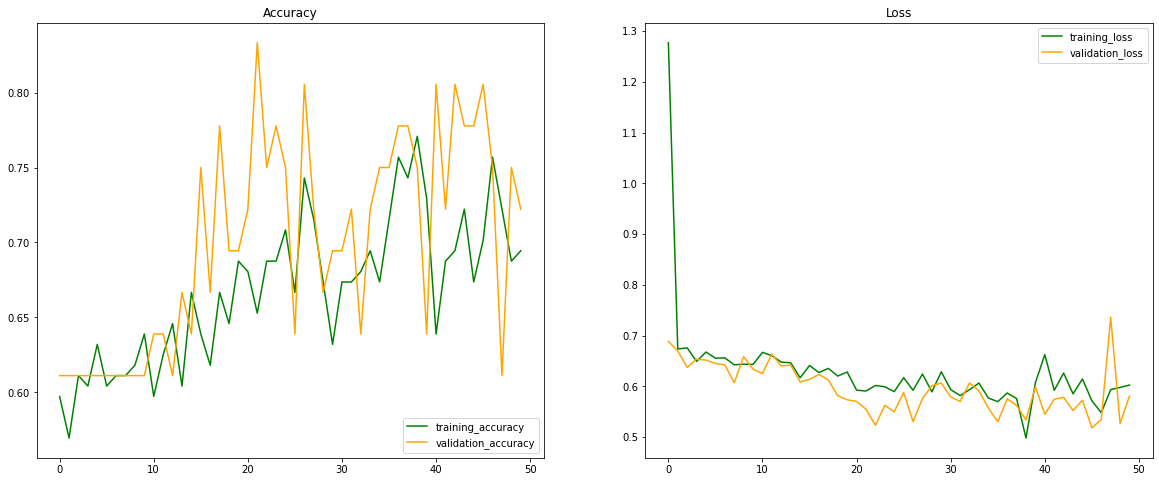

In [33]:
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(50)
plt.plot(epochs, train_acc, label = 'training_accuracy', color = 'green')
plt.plot(epochs, val_acc, label = 'validation_accuracy', color = 'orange')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(50)
plt.plot(epochs, train_loss, label = 'training_loss', color = 'green')
plt.plot(epochs, val_loss, label = 'validation_loss', color = 'orange')
plt.legend(loc = 'upper right')
plt.title('Loss')

plt.show()






In [34]:
for data_batch in test_generator:
    pred = model.predict(data_batch[0])
    pred_indices = np.argmax(pred, axis = 1)
    break

1/1 [==============================] - 1s 594ms/step


In [35]:
pred_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

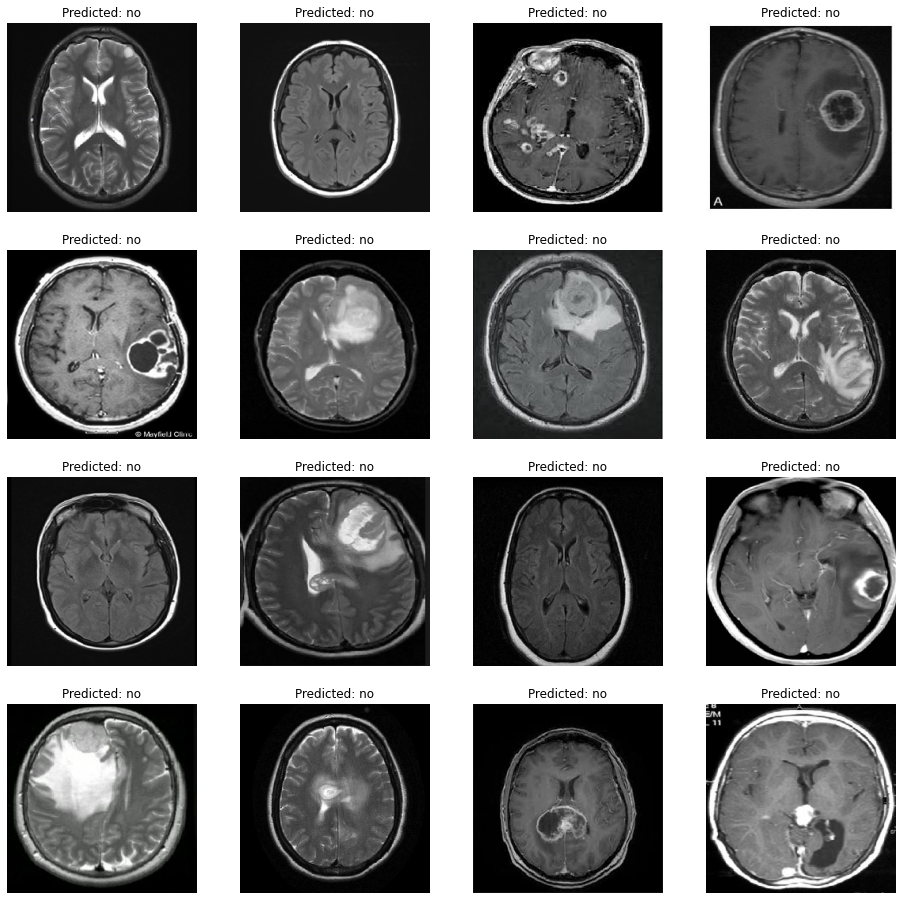

In [36]:
plt.figure(figsize = (16, 16))

for i in range(data_batch[0].shape[0]):
    plt.subplot(4, 4, i+1)
    pred_label = labels[pred_indices[i]]
    plt.imshow(data_batch[0][i])
    plt.title(f'Predicted: {pred_label}')
    plt.axis('off')

In [59]:
def predict_tumor(filepath):
    img = load_img(filepath, target_size = (240, 240))
    img_array = img_to_array(img)
    img_array = img_array/255
    img_array = np.expand_dims(img_array, axis = 0)
    
    class_ = model.predict([img_array])
    pred_indices = int(np.round(class_)[0])          #np.round instead of np.argmax because we have only one output between 0 to 1
    print(pred_indices)
    class_name = labels[pred_indices]
    
    im = mpimg.imread(filepath)
    plt.imshow(im)
    print(f'Predicted label:', class_name)
    

1/1 [==============================] - 0s 45ms/step
0
Predicted label: no


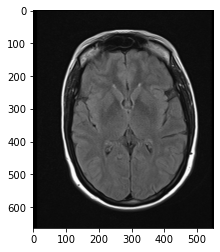

In [60]:
predict_tumor(r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\testing\test\no 96.jpg')

1/1 [==============================] - 0s 39ms/step
1
Predicted label: yes


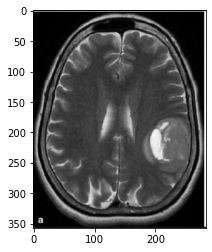

In [61]:
predict_tumor(r'C:\Users\Sahil\DS ML tests\Project Brain MRI tumour\testing\test\Y99.jpg')